## Supernovae and redshifts (Regression, Dynesty, Odds Ratio, Cloning)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

![Screen%20Shot%202022-05-01%%2010.48.48.png](attachment:Screen%20Sho20att%202022-05-01%20at%2010.48.48.png)

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [481]:
 
#TODO: model comparison in theoretical model
#TODO: Sampling ESA

In [482]:
import matplotlib.pyplot as plt
import numpy as np

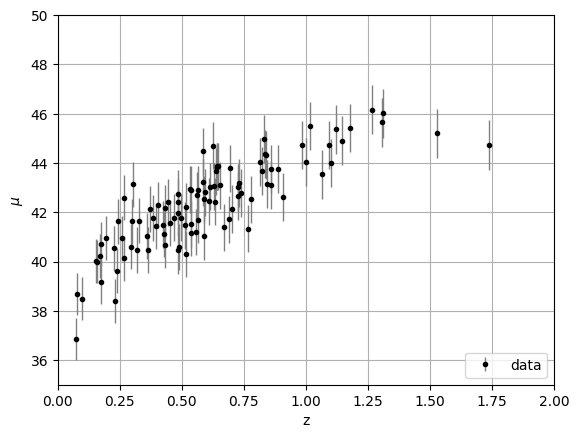

In [483]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid()

### Linear Regression

In [484]:
from sklearn.linear_model import LinearRegression
X = z_sample[:,None]
y = mu_sample
dy = dmu
lg = LinearRegression().fit(X,y,dy)

X_grid = np.linspace(0., 2., 1000)


In [485]:
theta0 = lg.intercept_
theta1 = lg.coef_

print(theta0, theta1)
y_pred = lg.predict(X_grid[:,None])

39.60456481105869 [4.5911933]


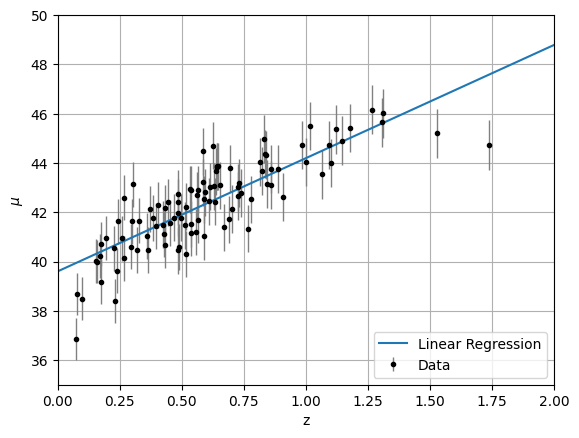

In [486]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(X_grid, y_pred, label='Linear Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid()

### Polynomial Regression

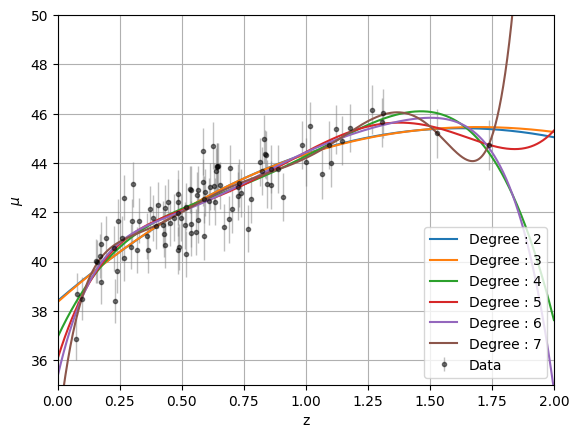

In [505]:
from astroML.linear_model import PolynomialRegression
degrees = np.arange(2,8,1)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data', alpha = 0.5)


for degree in degrees:
    pr = PolynomialRegression(degree).fit(X,y,dy)

    y_pred = pr.predict(X_grid[:, None])


    plt.plot(X_grid, y_pred, label='Degree : {}'.format(degree))
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend(loc='lower right')
    plt.xlim(0,2)
    plt.ylim(35,50)
plt.grid()

In order to find the best degree that describes the data having a polynomial model, a cross-validation approach is used. 

### Cross - validation

In [488]:
from sklearn.model_selection import train_test_split
import random

def getCVsets(data, test_size=0.3):
    X, y, dy = data
    random_n = random.randint(0, 10000)
    X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=test_size, random_state=random_n)#, shuffle=True)
    y_train,dy_train = ydy_train.T
    y_validation,dy_validation = ydy_validation.T

    return X_train, X_validation, y_train, dy_train, y_validation,dy_validation

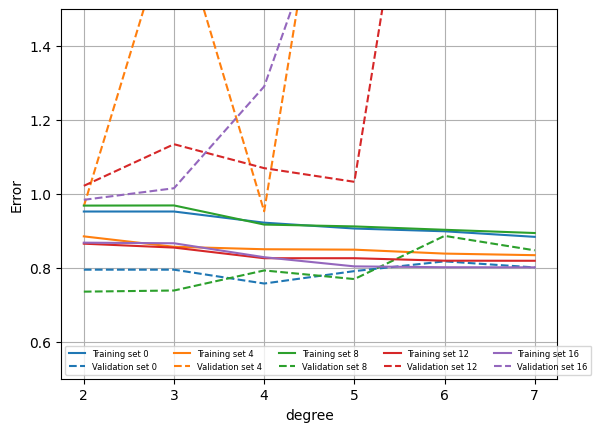

In [489]:
from sklearn.model_selection import train_test_split
import random

n_splits=20
best_n_val = []
for _ in range(n_splits):
    rand_n = random.randint(0, 10000)
    X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=0.3, random_state=rand_n)#, shuffle=True)
    y_train,dy_train = ydy_train.T
    y_validation,dy_validation = ydy_validation.T

    err_train = []
    err_val = []


    for d in degrees:
        model = PolynomialRegression(d)
        model.fit(X_train, y_train, dy_train)

        err_train.append(np.sqrt(np.sum((y_train - model.predict(X_train)) ** 2)/ len(X_train)))
        err_val.append(np.sqrt(np.sum((y_validation - model.predict(X_validation)) ** 2)/ len(X_validation)))

    #just show some splits
    if _%4 == 0:
        plot, = plt.plot(degrees,err_train, label='Training set {}'.format(_))
        plt.plot(degrees,err_val,label='Validation set {}'.format(_), linestyle='--', color=plot.get_color())
    
    best_n_val.append(degrees[np.argmin(err_val)])

plt.xlabel('degree')
plt.ylabel('Error')
plt.ylim(0.5, 1.5)
plt.legend(ncol = 5, prop={'size': 6})
plt.grid()

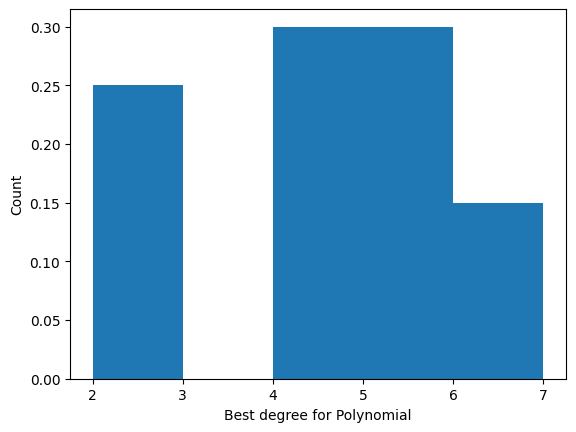

In [493]:
plt.hist(best_n_val, bins=degrees, density=True)
plt.xlabel('Best degree for Polynomial')
plt.ylabel('Count')
plt.show()


In [495]:
print('Median : ', np.median(best_n_val))

Median :  4.0


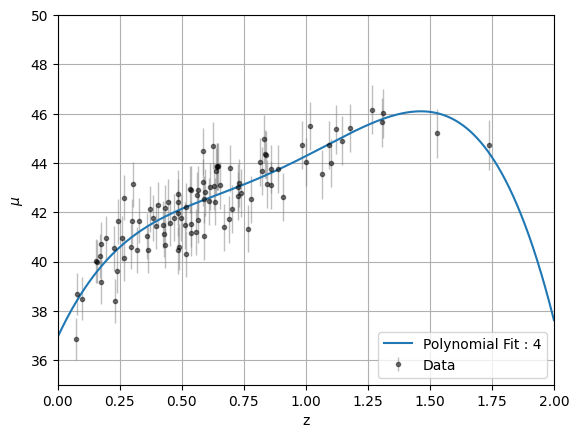

In [498]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data', alpha = 0.5)


degree = int(np.median(best_n_val))
pr = PolynomialRegression(degree).fit(X,y,dy)

y_pred = pr.predict(X_grid[:, None])


plt.plot(X_grid, y_pred, label='Polynomial Fit : {}'.format(degree))
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid()

### Basis Function Regression (with CV)

In [500]:
from astroML.linear_model import BasisFunctionRegression

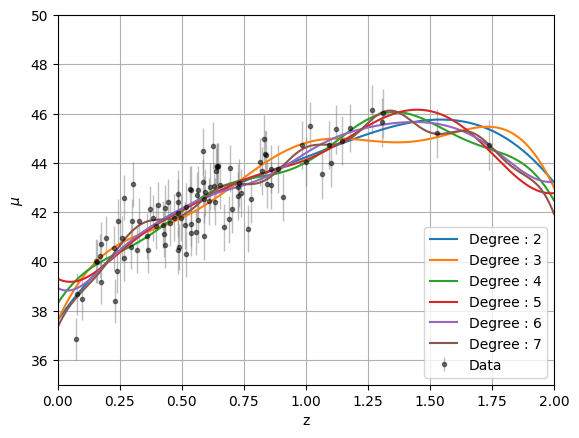

In [506]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data', alpha = 0.5)
for n in degrees:
        mu_gaussians = np.linspace(0, 2, int(n))[:, None]
    
        sigma_gaussian = 0.5 * mu_gaussians[1] - mu_gaussians[0]

        model = BasisFunctionRegression('gaussian', mu=mu_gaussians, sigma=sigma_gaussian)
        model.fit(X, y, dy)
        y_pred = model.predict(X_grid[:, None])


        plt.plot(X_grid, y_pred, label='Degree : {}'.format(n))
        plt.xlabel("z")
        plt.ylabel("$\mu$")
        plt.legend(loc='lower right')
        plt.xlim(0,2)
        plt.ylim(35,50)
plt.grid()
        

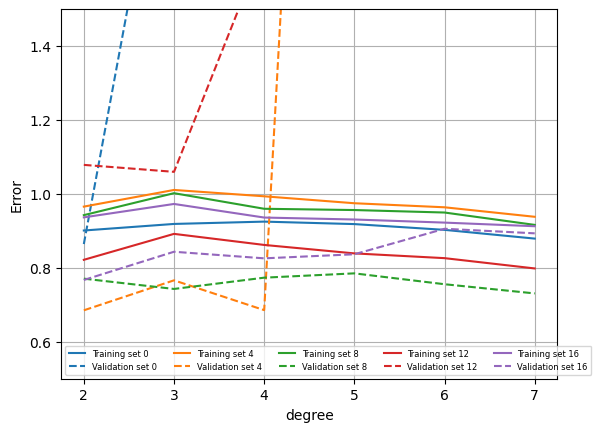

In [501]:
from sklearn.model_selection import train_test_split
import random

n_splits=20
best_n_val = []
for _ in range(n_splits):
    rand_n = random.randint(0, 10000)
    X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=0.3, random_state=rand_n)#, shuffle=True)
    y_train,dy_train = ydy_train.T
    y_validation,dy_validation = ydy_validation.T

    err_train = []
    err_val = []


    for n in degrees:
        mu_gaussians = np.linspace(0, 2, int(n))[:, None]
    
        sigma_gaussian = 0.5 * mu_gaussians[1] - mu_gaussians[0]

        model = BasisFunctionRegression('gaussian', mu=mu_gaussians, sigma=sigma_gaussian)
        model.fit(X_train, y_train, dy_train)

        err_train.append(np.sqrt(np.sum((y_train - model.predict(X_train)) ** 2)/ len(X_train)))
        err_val.append(np.sqrt(np.sum((y_validation - model.predict(X_validation)) ** 2)/ len(X_validation)))

    #just show some splits
    if _%4 == 0:
        plot, = plt.plot(degrees,err_train, label='Training set {}'.format(_))
        plt.plot(degrees,err_val,label='Validation set {}'.format(_), linestyle='--', color=plot.get_color())
    
    best_n_val.append(degrees[np.argmin(err_val)])

plt.xlabel('degree')
plt.ylabel('Error')
plt.ylim(0.5, 1.5)
plt.legend(ncol = 5, prop={'size': 6})
plt.grid()

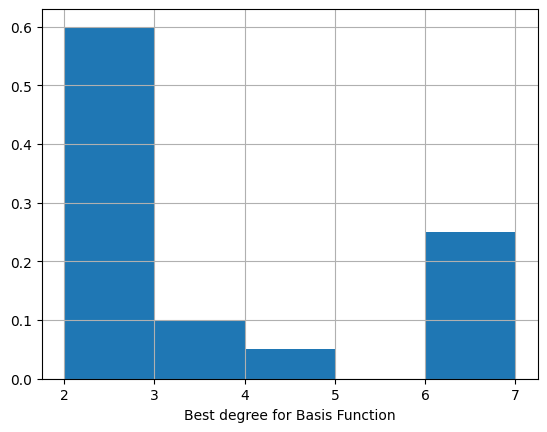

In [508]:
plt.hist(best_n_val, bins=degrees, density=True)
plt.xlabel('Best degree for Basis Function')
plt.grid()
plt.show()


In [509]:
print('Median : ', np.median(best_n_val))

Median :  2.0


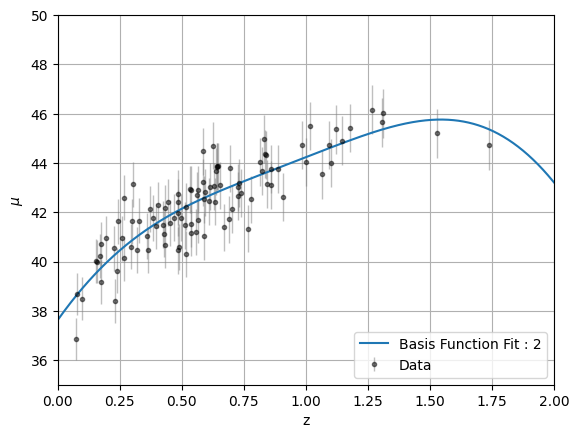

In [511]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data', alpha = 0.5)


n = int(np.median(best_n_val))

mu_gaussians = np.linspace(0, 2, int(n))[:, None]
sigma_gaussian = 0.5 * mu_gaussians[1] - mu_gaussians[0]

model = BasisFunctionRegression('gaussian', mu=mu_gaussians, sigma=sigma_gaussian).fit(X, y, dy)

y_pred = model.predict(X_grid[:, None])


plt.plot(X_grid, y_pred, label='Basis Function Fit : {}'.format(n))
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid()

________________________

## Gaussian Process Regression (GPR)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [691]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

In [695]:
#Cross-validation on n_splits
params = np.linspace(0.1, 10.1, 100)
n_splits=20
best_n_val = []

for _ in range(n_splits):
    rand_n = random.randint(0, 10000)
    X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=0.3, random_state=rand_n)#, shuffle=True)
    y_train,dy_train = ydy_train.T
    y_validation,dy_validation = ydy_validation.T

    err_train_tmp = [] 
    err_val_tmp = []

    #for p in params:
    for p in params:
        #kernel = p[0] * RBF(p[1]) 
        kernel = 0.5 * RBF(p)
        model = GaussianProcessRegressor(kernel=kernel, alpha=dy_validation**2)
        model.fit(X_validation,y_validation)
        
        err_train_tmp.append(np.sqrt(np.sum((y_train - model.predict(X_train)) ** 2)/ len(X_train)))
        err_val_tmp.append(np.sqrt(np.sum((y_validation - model.predict(X_validation)) ** 2)/ len(X_validation)))

    ind = np.argmin(err_val_tmp)
    best_n_val.append(params[ind])
    #print(params[ind])







In [696]:
best_n = np.median(best_n_val)
print(best_n)

5.302020202020202


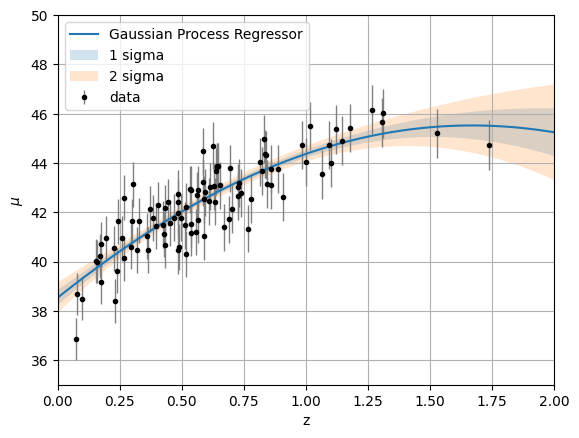

In [697]:
        
kernel = 0.5 * RBF(best_n)
model_gpr = GaussianProcessRegressor(kernel=kernel, alpha=dy**2)
model_gpr.fit(X,y)
y_pred, dy_pred = model_gpr.predict(X_grid[:, None], return_std=True)


plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

plt.plot(X_grid, y_pred, label='Gaussian Process Regressor')
plt.fill_between(X_grid, y_pred - dy_pred, y_pred + dy_pred, alpha =0.2, label='1 sigma')
plt.fill_between(X_grid, y_pred - 2*dy_pred, y_pred + 2*dy_pred, alpha=0.2, label='2 sigma')

plt.grid()
plt.legend()

## Theoretical Model

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fir it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



In [639]:
from astropy.cosmology import LambdaCDM
import scipy.stats
import emcee
import corner

In [640]:
data = np.array([z_sample, mu_sample, dmu]).T
print(data.shape)


(100, 3)


In [700]:
def model(z, theta):
    H0, Om = theta
    cosmo = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo.distmod(z).value

/opt/homebrew/lib/python3.11/site-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


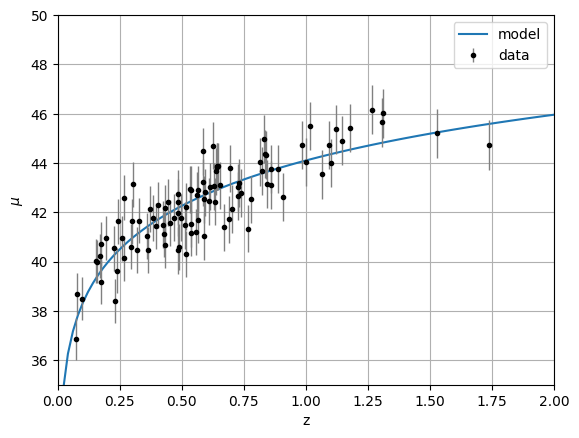

In [642]:
#H0 = 70, Omega_matter = 0.3 ->Omega_darkenergy = 0.7
theta_guess = 70, 0.3
zgrid = np.linspace(0,2,100)

plt.plot(zgrid, model(zgrid, theta_guess), label = 'model')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.grid()

## Bayesian Parameter Estimation (Nested Sampling with dynesty)

#### With Dark Energy

In [657]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [679]:
#2 params
def model_darkenergy(theta,z):
    H0, Om = theta
    cosmo = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo.distmod(z).value


In [680]:
H0_min, H0_max= 40, 100
Om_min, Om_max = 0.1, 1

def LogLikelihood(theta, data, model):
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 )


def prior_transform(u):
    
    mins = [H0_min,Om_min]
    maxs = [H0_max,Om_max]
    
    x = mins + u* maxs-mins
    
    return x

data = z_sample, mu_sample, dmu
sampler = dynesty.NestedSampler(LogLikelihood, prior_transform, ndim=2,logl_args=[data,model_darkenergy]) 
sampler.run_nested()
sresults_darkenergy = sampler.results

1872it [00:07, 246.54it/s, +500 | bound: 1 | nc: 1 | ncall: 18536 | eff(%): 13.151 | loglstar:   -inf < -46.386 <    inf | logz: -49.273 +/-  0.056 | dlogz:  0.001 >  0.509]


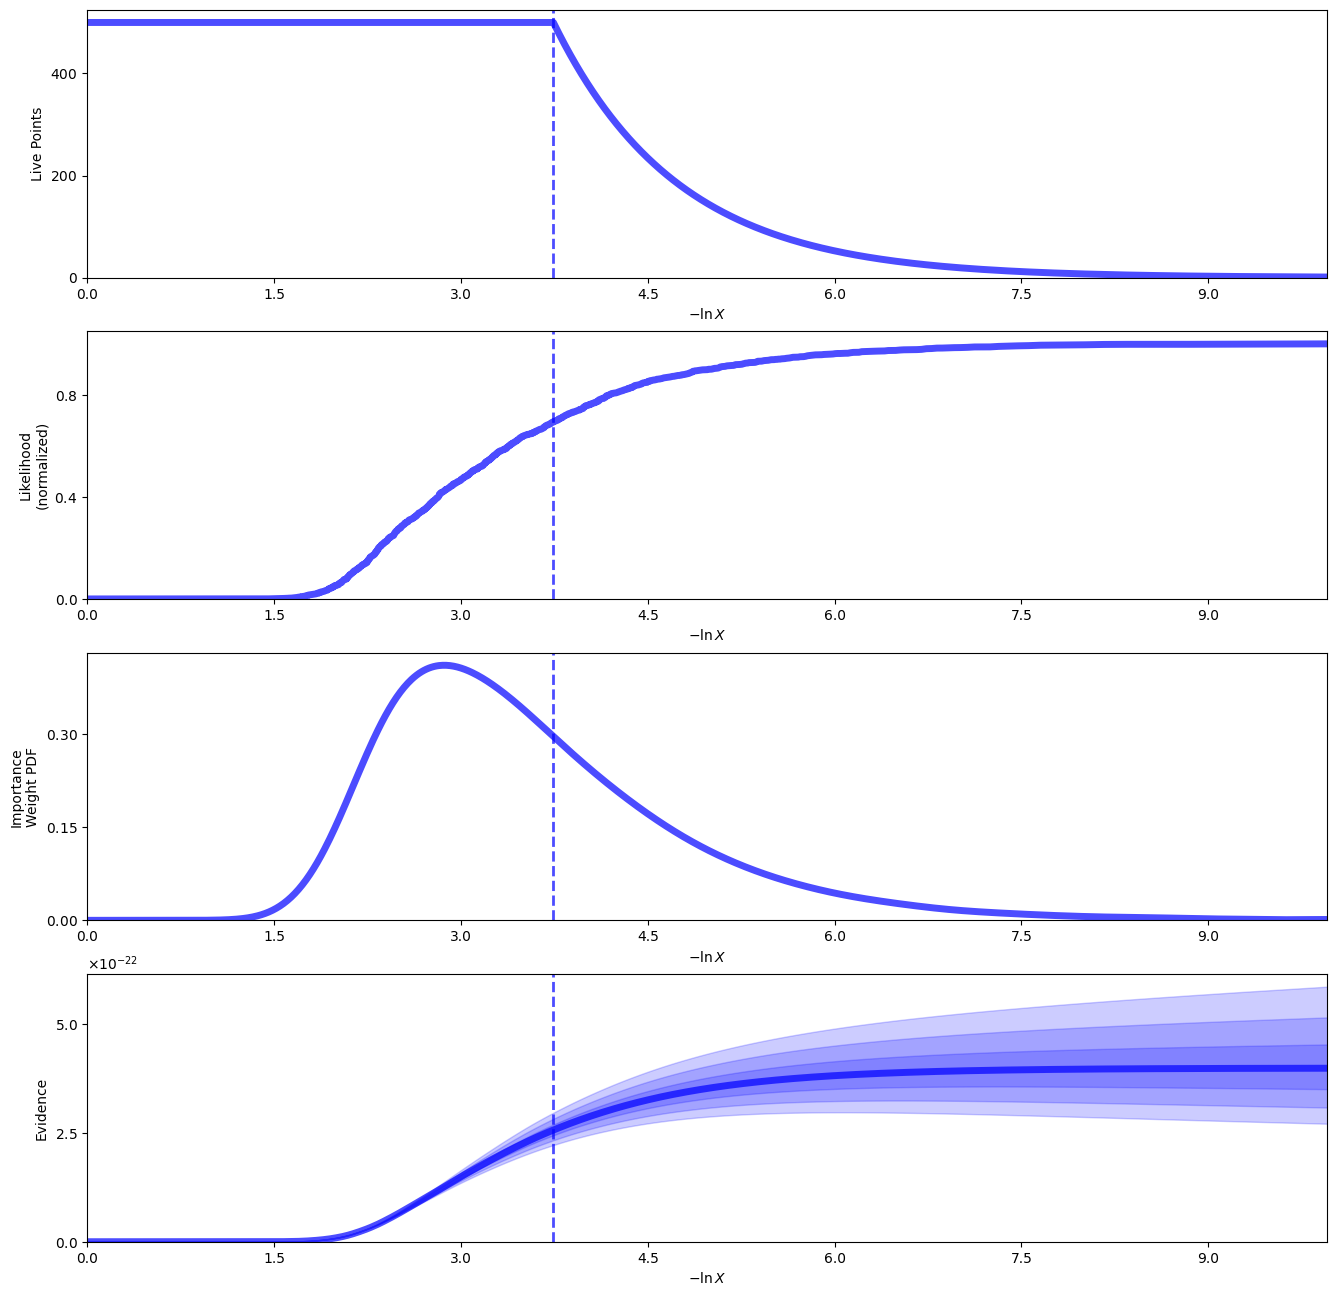

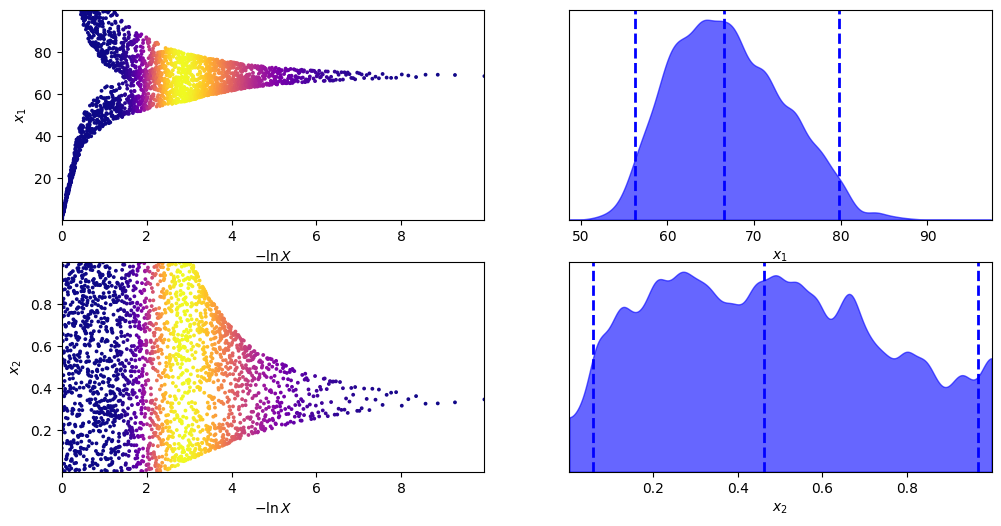

In [681]:
rfig, raxes = dyplot.runplot(sresults_darkenergy)
tfig, taxes = dyplot.traceplot(sresults_darkenergy)

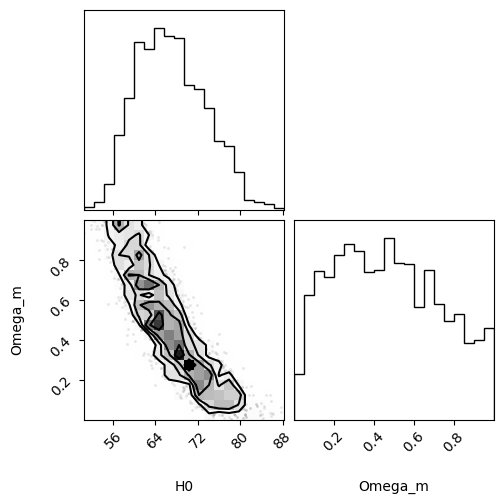

In [682]:
samples = sresults_darkenergy.samples  # samples
weights = np.exp(sresults_darkenergy.logwt - sresults_darkenergy.logz[-1])  # normalized weights

theta_titles = ['H0', 'Omega_m']

samples_equal_darkenergy = dyfunc.resample_equal(samples, weights) 
corner.corner(samples_equal_darkenergy,labels=theta_titles, use_math_text=True);

In [683]:
quantiles = [dyfunc.quantile(samps, [0.1, 0.5, 0.90], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,theta_titles):
    low,med,up=q
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))

H0	=	66.48	+9.42	-7.51
Omega_m	=	0.46	+0.38	-0.33


#### Without Dark Energy

In [685]:
#1 param
def model_nodarkenergy(theta,z):
    H0 = float(theta) #else: non scalar quantity and gives error
    cosmo = LambdaCDM(H0=H0, Om0=1., Ode0=0.)
    return cosmo.distmod(z).value

In [686]:
H0_min, H0_max= 40., 100.

def LogLikelihood(theta, data, model):
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 )


def prior_transform(u):
    
    mins = np.array([40.])
    maxs = np.array([100.])
    
    x = mins + u* maxs-mins
    
    return x

data = z_sample, mu_sample, dmu
sampler_nodarkenergy = dynesty.NestedSampler(LogLikelihood, prior_transform, ndim=1,logl_args=[data,model_nodarkenergy]) 
sampler_nodarkenergy.run_nested()
sresults_nodarkenergy = sampler_nodarkenergy.results

1902it [00:07, 265.33it/s, +500 | bound: 1 | nc: 1 | ncall: 19232 | eff(%): 12.823 | loglstar:   -inf < -47.102 <    inf | logz: -49.999 +/-  0.052 | dlogz:  0.001 >  0.509]


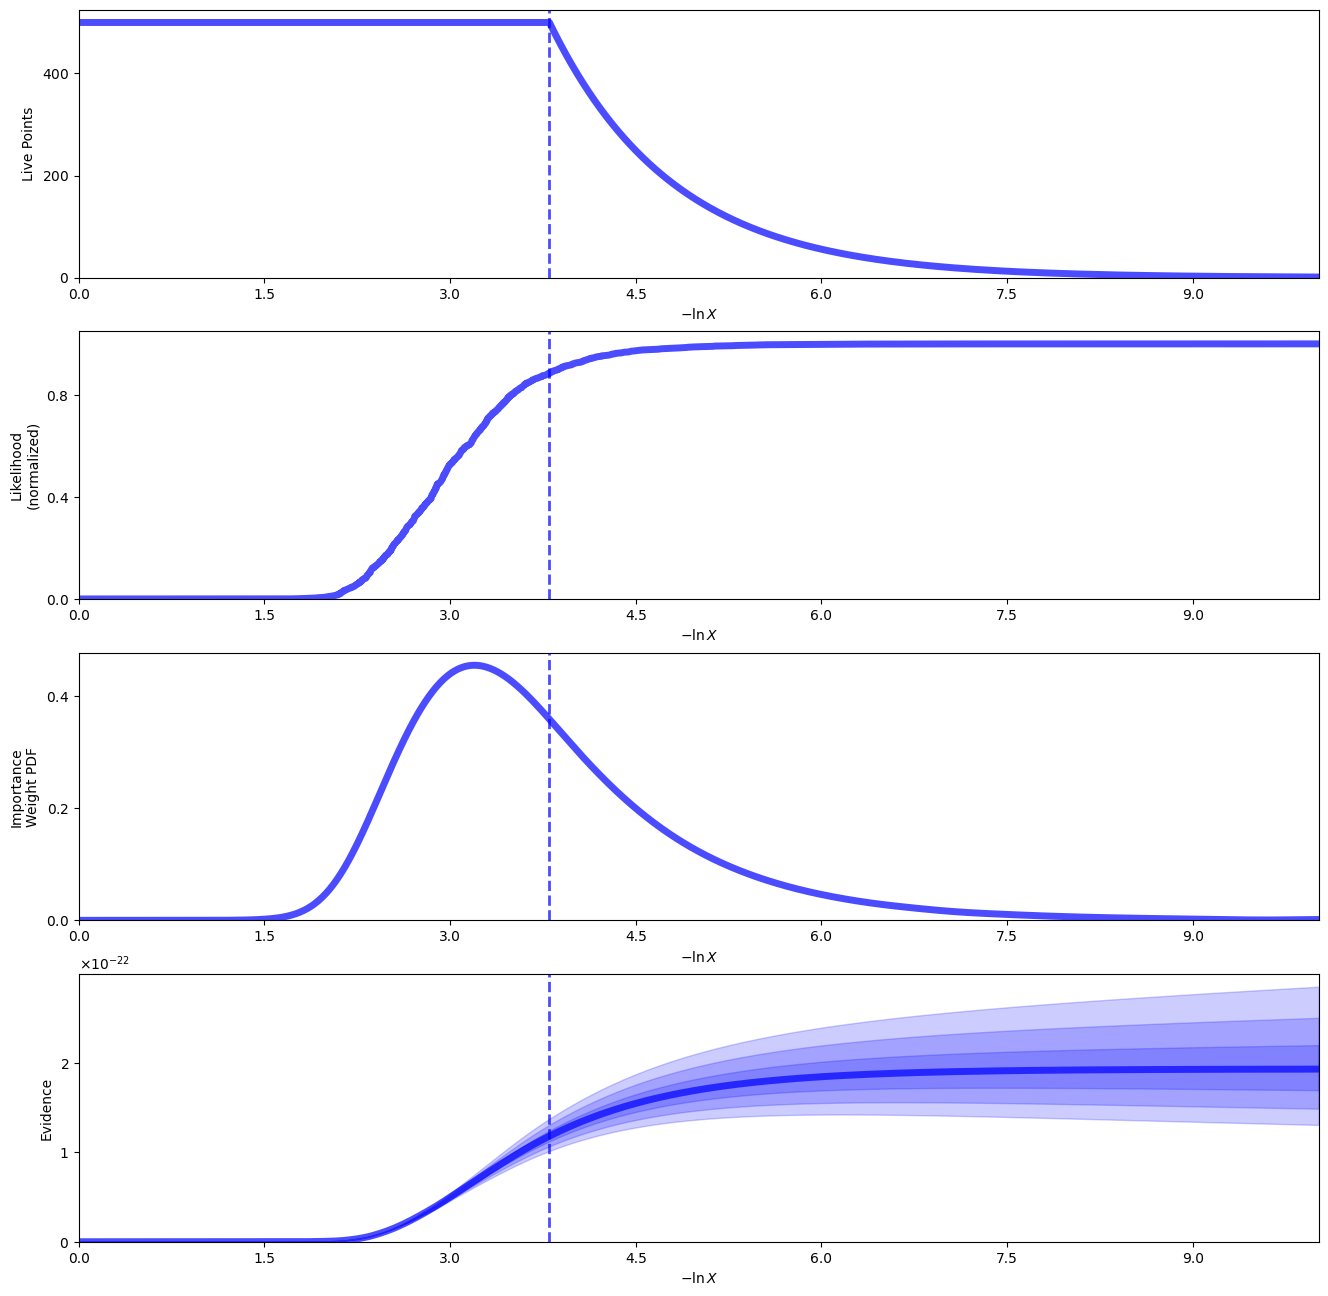

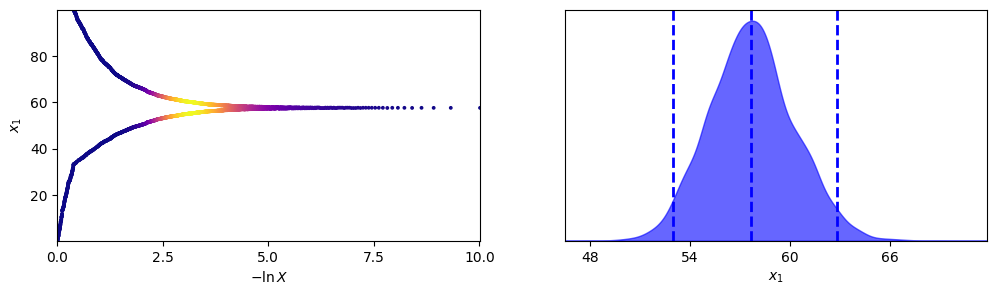

In [687]:
rfig, raxes = dyplot.runplot(sresults_nodarkenergy)
tfig, taxes = dyplot.traceplot(sresults_nodarkenergy)

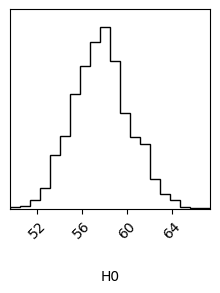

In [688]:
samples = sresults_nodarkenergy.samples  # samples
weights = np.exp(sresults_nodarkenergy.logwt - sresults_nodarkenergy.logz[-1])  # normalized weights

theta_titles = ['H0']

samples_equal_nodarkenergy = dyfunc.resample_equal(samples, weights) 
corner.corner(samples_equal_nodarkenergy,labels=theta_titles, use_math_text=True);

In [689]:
quantiles = [dyfunc.quantile(samps, [0.1, 0.5, 0.90], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,theta_titles):
    low,med,up=q
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))

H0	=	57.67	+3.47	-3.15


In [690]:
Evidence_darkenergy = np.exp(sresults_darkenergy.logz[-1])
Evidence_nodarkenergy= np.exp(sresults_nodarkenergy.logz[-1])
Odds = Evidence_darkenergy/Evidence_nodarkenergy
print('Odds ratio =', Odds)

Odds ratio = 2.0683819153710252


The Odds ratio barely favoures the model with dark energy.

## Cloning Sample

In [703]:
z_uniform = np.random.uniform(np.min(z_sample),np.max(z_sample), 1000) #generate uniformely z 

y_nested=[]
y_gpr=[]

for z in z_uniform:
    theta = samples_equal_darkenergy[np.random.choice(samples_equal_darkenergy.shape[0])] #randomly chooses H0 and Omega_m according to the computations of dynesty   
    y_nested.append(model(z,theta))
    
    y_fit, sigma_y = model_gpr.predict([[z]], return_std=True)
    y_gpr.append(np.random.normal(loc=y_fit,scale=sigma_y))
    

(35.0, 50.0)

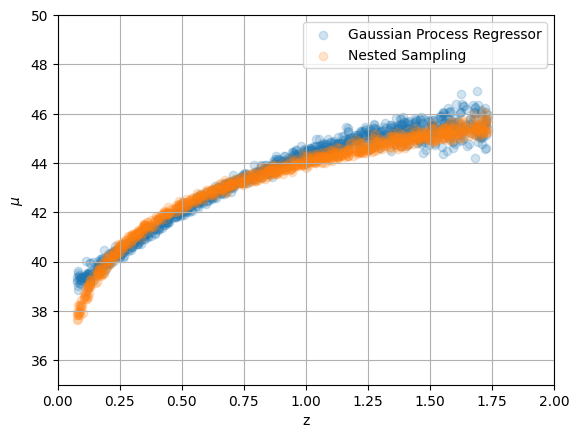

In [707]:

plt.scatter(z_uniform, y_gpr, label = 'Gaussian Process Regressor', alpha=0.2)
plt.scatter(z_uniform, y_nested, label = 'Nested Sampling', alpha=0.2)
plt.grid()
plt.legend()
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)